<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [114]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

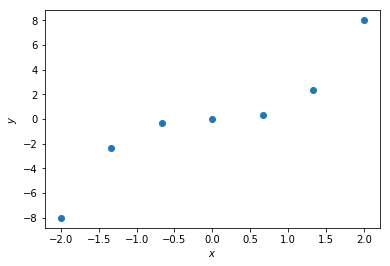

In [115]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [116]:
round(np.mean(y))# Ваш код здесь

-0.0

In [117]:
y1 = [np.mean(y) for x in X]

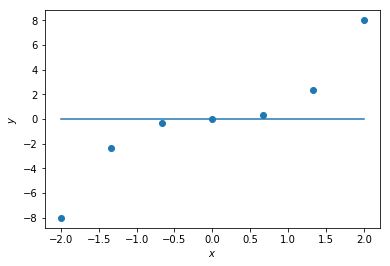

In [118]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.plot(X,y1)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [119]:
y2 = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0]) for x in X]

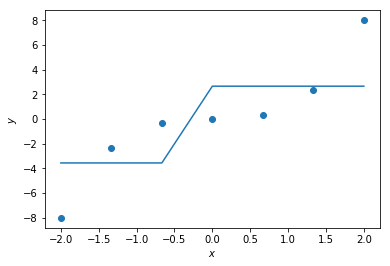

In [120]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.plot(X,y2)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [121]:
#Мат. ожидание
def M(X):
    sum = 0
    for x in X:
        sum += x
    return sum/len(X)

In [122]:
M(y)

-2.5376526277146434e-16

In [123]:
# дисперсия
def D(X):
    sum = 0
    for x in X:
        sum += (x - M(X))**2
    return sum/len(X)

In [124]:
D(y)

19.916127767979617

In [125]:
def regression_var_criterion(X, y, t):
    x1 = X[X<t]
    x2 = X[X>=t]
    y1 = y[X<t]
    y2 = y[X>=t]
    return D(y) - len(x1)/len(X)*D(y1) - len(x2)/len(X)*D(y2)

In [126]:
T = np.linspace(-1.9, 1.9, 100)

In [127]:
y3 = [regression_var_criterion(X,y,t) for t in T]

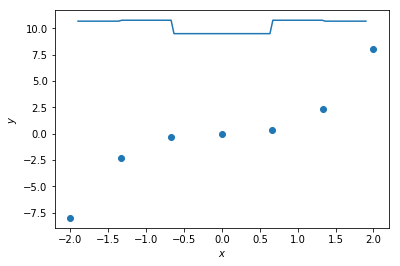

In [128]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.plot(T,y3)

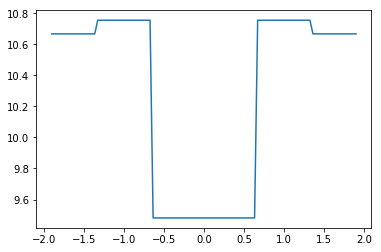

In [129]:
plt.plot(T,y3)

In [130]:
# Ваш код здесь

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да

**- Нет**

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [131]:
def predict(X,y,x):
    if x<0:
        if x<-1.5:
            return np.mean(y[X<-1.5])
        else:
            return np.mean(y[(X>=-1.5)&(X<0)])
    else:
        if x<1.5:
            return np.mean(y[(X<1.5)&(X>=0)])
        else:
            return np.mean(y[X>=1.5])

In [132]:
y[(X>=-1.5)&(X<0)]

array([-2.37037037, -0.2962963 ])

In [133]:
(X<0)&(X>-1)

array([False, False,  True, False, False, False, False])

In [134]:
X2 = np.linspace(-2,2,100)

In [135]:
y4 = [predict(X,y,x) for x in X2 ] 

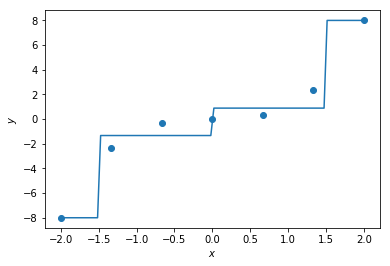

In [136]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');
plt.plot(X2,y4)

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
***
- 7
***
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [137]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [138]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [139]:
df['age_year'] = df['age'] // 365.25

In [140]:
df['gluc'] = df['gluc'] + 3

In [141]:
df = df.join(pd.DataFrame(pd.get_dummies(df['cholesterol'])));

In [142]:
df = df.join(pd.DataFrame(pd.get_dummies(df['gluc'])))

In [143]:
df.drop(['cholesterol', 'gluc', 'age'], axis=1, inplace=True)
#df.drop(['cholesterol', 'gluc'], axis=1, inplace=True)

In [144]:
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_year,1,2,3,4,5,6
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55.0,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,51.0,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48.0,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,0,47.0,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [145]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['cardio'], axis=1), df['cardio'], test_size=0.3
                                                      , random_state=17) # Ваш код здесь

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [146]:
clf = DecisionTreeClassifier(max_depth=3, random_state=17)

In [147]:
%%time
clf.fit(X_train, y_train);

CPU times: user 46.8 ms, sys: 0 ns, total: 46.8 ms
Wall time: 46.2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [148]:
export_graphviz(clf, feature_names=X_train.columns, out_file='../../img/zm_tree.dot', filled=True)

Для отрисовки дерева:
http://www.webgraphviz.com/


In [149]:
!dot -Tpng '../../img/zm_tree.dot' -o '../../img/zm_tree.png'

<img src='../../img/zm_tree.png'>

In [150]:
X_train.columns[clf.feature_importances_>0] # clf.feature_importances_>0X. # clf.feature_importances_>0

Index(['ap_hi', 'age_year', 3], dtype='object')

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- <b>age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [151]:
acc1 = accuracy_score(clf.predict(X_valid), y_valid)
acc1

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [152]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(clf, tree_params, cv=5, return_train_score=True) # Ваш код здесь

In [153]:
%%time
tree_grid.fit(X_train, y_train,)

CPU times: user 2.83 s, sys: 0 ns, total: 2.83 s
Wall time: 2.83 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [154]:
tree_grid.cv_results_

{'mean_fit_time': array([0.0205008 , 0.02473078, 0.03193307, 0.04850121, 0.05866694,
        0.06446872, 0.06929898, 0.06051021, 0.08025765]),
 'mean_score_time': array([0.00192199, 0.00174112, 0.00185637, 0.00269012, 0.00230374,
        0.00232587, 0.00244889, 0.00212736, 0.00277853]),
 'mean_test_score': array([0.7155102 , 0.72771429, 0.73069388, 0.73110204, 0.73220408,
        0.73008163, 0.73036735, 0.728     , 0.72626531]),
 'mean_train_score': array([0.71551022, 0.7277143 , 0.73069389, 0.73331124, 0.73540818,
        0.73966838, 0.74447451, 0.75039798, 0.75704084]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'ran

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

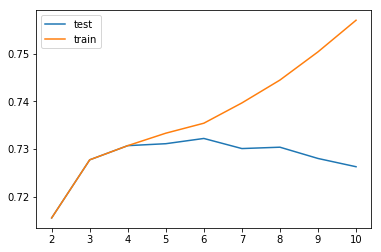

In [155]:
# Ваш код здесь
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score'], label='test')
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_train_score'], label='train')
plt.legend()

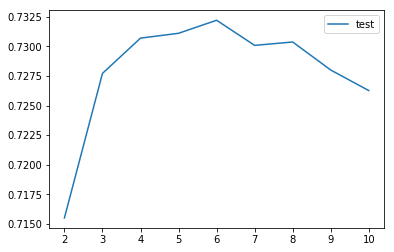

In [156]:
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score'], label='test')
plt.legend()

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [157]:
# Ваш код здесь
tree_grid.best_score_, tree_grid.best_params_

(0.732204081632653, {'max_depth': 6})

In [158]:
clf = DecisionTreeClassifier(max_depth=6, random_state=17)

In [159]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [160]:
acc2 = accuracy_score(clf.predict(X_valid), y_valid)
acc2

0.7256666666666667

In [161]:
(acc2 - acc1) / acc1 * 100

0.6073809995378613

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да

<b>- да, нет</b>
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 16 columns):
gender      70000 non-null int64
height      70000 non-null int64
weight      70000 non-null float64
ap_hi       70000 non-null int64
ap_lo       70000 non-null int64
smoke       70000 non-null int64
alco        70000 non-null int64
active      70000 non-null int64
cardio      70000 non-null int64
age_year    70000 non-null float64
1           70000 non-null uint8
2           70000 non-null uint8
3           70000 non-null uint8
4           70000 non-null uint8
5           70000 non-null uint8
6           70000 non-null uint8
dtypes: float64(2), int64(8), uint8(6)
memory usage: 8.8 MB


In [166]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [167]:
df['age_year'] = df['age'] // 365.25

In [169]:
df5 = pd.DataFrame(df.smoke.copy())
df5['male']  = df.gender - 1

df5['age_45_50'] = ((df.age_year >= 45) & (df.age_year < 50) ).astype('int')
df5['age_50_55'] = ((df.age_year >= 50) & (df.age_year < 55) ).astype('int')
df5['age_55_60'] = ((df.age_year >= 55) & (df.age_year < 60) ).astype('int')
df5['age_60_65'] = ((df.age_year >= 60) & (df.age_year < 65) ).astype('int')
df5['ap_hi_120_140'] = ((df.ap_hi >= 120) & (df.ap_hi < 140)).astype('int')
df5['ap_hi_140_160'] = ((df.ap_hi >= 140) & (df.ap_hi < 160)).astype('int')
df5['ap_hi_160_180'] = ((df.ap_hi >= 160) & (df.ap_hi < 180)).astype('int')

df5['chol=1'] = (df.cholesterol == 1).astype('int')
df5['chol=2'] = (df.cholesterol == 2).astype('int')
df5['chol=3'] = (df.cholesterol == 3).astype('int')

In [170]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
smoke            70000 non-null int64
male             70000 non-null int64
age_45_50        70000 non-null int64
age_50_55        70000 non-null int64
age_55_60        70000 non-null int64
age_60_65        70000 non-null int64
ap_hi_120_140    70000 non-null int64
ap_hi_140_160    70000 non-null int64
ap_hi_160_180    70000 non-null int64
chol=1           70000 non-null int64
chol=2           70000 non-null int64
chol=3           70000 non-null int64
dtypes: int64(12)
memory usage: 6.9 MB


In [171]:
df5.head(10)

,smoke,male,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol=1,chol=2,chol=3
id,,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,0,1,0,0,0,1,0
9,0,0,0,0,0,1,1,0,0,0,0,1
12,0,1,0,0,0,1,1,0,0,0,0,1
13,0,0,1,0,0,0,0,0,0,1,0,0


In [174]:
clf = DecisionTreeClassifier(max_depth=3, random_state=17)

In [176]:
y = df['cardio']

In [177]:
clf.fit(df5, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [178]:
export_graphviz(clf, feature_names=df5.columns, out_file='../../img/zm_tree_5.dot', filled=True)

In [179]:
!dot -Tpng '../../img/zm_tree_5.dot' -o '../../img/zm_tree_5.png'

<img src = '../../img/zm_tree_5.png'>

In [181]:
df5[df['age_year']<45].head(10)

,smoke,male,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol=1,chol=2,chol=3
id,,,,,,,,,,,,
18,0,1,0,0,0,0,1,0,0,1,0,0
23,1,1,0,0,0,0,1,0,0,1,0,0
36,0,0,0,0,0,0,1,0,0,0,1,0
39,0,1,0,0,0,0,1,0,0,1,0,0
44,0,0,0,0,0,0,0,0,0,1,0,0
64,0,0,0,0,0,0,1,0,0,1,0,0
68,0,0,0,0,0,0,1,0,0,0,0,1
73,1,1,0,0,0,0,0,1,0,1,0,0
103,0,1,0,0,0,0,0,1,0,0,1,0
